In [3]:
%run ../utils_rf

In [4]:
#read training data
file = file = "../../../tables/model_input/noc_answers.csv"
x, x_agg, y, y_agg, x_noclvl, y_noclvl = data_proccess(file,True)

In [6]:
#running initial models
pred = run_models(x, x_agg, y, y_agg,False,True,120,120)
increase_pred = run_models(x, x_agg, y, y_agg,True,True,121,121)
decrease_pred = run_models(x, x_agg, y, y_agg,True,False,121,121)
increase_noclvl_pred = run_k_fold(x_noclvl,y_noclvl['increase'],init_params('reg'),x_noclvl.index,True,'reg')
decrease_noclvl_pred = run_k_fold(x_noclvl,y_noclvl['decrease'],init_params('reg'),x_noclvl.index,True,'reg')

y_agg = y_agg[['constant','decrease','increase']]

# #getting accuracy scores
pred_acc = abs(pd.DataFrame(np.matrix(pred) 
                            - np.matrix(pd.concat([y_agg,y_agg],axis=1)),index=pred.index,columns=pred.columns))
increase_acc = abs(increase_pred.subtract(y_agg['increase'],axis=0))
decrease_acc = abs(decrease_pred.subtract(y_agg['decrease'],axis=0))
increase_noclvl_acc = abs(increase_noclvl_pred.subtract(y_noclvl['increase'],axis=0))
decrease_noclvl_acc = abs(decrease_noclvl_pred.subtract(y_noclvl['decrease'],axis=0))

# #means and std deviations
performance = pd.concat([
    pd.concat([pred_acc.mean(),increase_acc.mean(),decrease_acc.mean(),
               increase_noclvl_acc.mean(),decrease_noclvl_acc.mean()]),
    pd.concat([pred_acc.std(),increase_acc.std(),decrease_acc.std(),
               increase_noclvl_acc.std(),decrease_noclvl_acc.std()])]
    ,axis=1)
performance.columns = ['mean','std']
performance.index = ['reg_con','reg_dec','reg_inc','prob_con','prob_dec','prob_inc',
                     'reg_bin_inc','prob_bin_inc','tree_bin_inc',
                     'reg_bin_dec','prob_bin_dec','tree_bin_dec',
                     'noclvl_inc','noclvl_dec']

#confusion matrices
pred_reg_confusion = confusion_matrix(pred[['regression_con','regression_dec','regression_inc']],y_agg,2)
pred_prob_confusion = confusion_matrix(pred[['prob_con','prob_dec','prob_inc']],y_agg,2)
inc_reg_confusion = confusion_matrix(increase_pred['regression'],y_agg['increase'],1)
inc_prob_confusion = confusion_matrix(increase_pred['pred_prob'],y_agg['increase'],1)
inc_tree_confusion = confusion_matrix(increase_pred['tree_portions'],y_agg['increase'],1)
dec_reg_confusion = confusion_matrix(decrease_pred['regression'],y_agg['decrease'],1)
dec_prob_confusion = confusion_matrix(decrease_pred['pred_prob'],y_agg['decrease'],1)
dec_tree_confusion = confusion_matrix(decrease_pred['tree_portions'],y_agg['decrease'],1)
inc_noclvl_confusion = confusion_matrix(increase_noclvl_pred[0],y_noclvl['increase'],1)
dec_noclvl_confusion = confusion_matrix(decrease_noclvl_pred[0],y_noclvl['decrease'],1)

ValueError: Found input variables with inconsistent numbers of samples: [45, 120, 45]

In [6]:
performance.sort_values('mean')

,mean,std
reg_con,0.120265,0.097892
prob_con,0.131288,0.104804
reg_inc,0.168018,0.138091
reg_bin_inc,0.176079,0.133585
reg_dec,0.176393,0.141939
reg_bin_dec,0.178063,0.144533
prob_bin_inc,0.193490,0.139700
prob_inc,0.195249,0.138516
noclvl_dec,0.196874,0.143379
tree_bin_inc,0.198396,0.152195


In [9]:
mean_absolute_error(y_agg,pred_acc[['regression_con','regression_con','regression_con']])

0.26836836116618773

In [10]:
mean_absolute_error(y_agg,pred_acc[['prob_con','prob_dec','prob_inc']])

0.24235585349197217

In [11]:
pred_reg_confusion

,pred_increase,pred_constant,pred_decrease
true_increase,32,1,4
true_constant,19,0,9
true_decrease,19,0,36


In [12]:
pred_prob_confusion

,pred_increase,pred_constant,pred_decrease
true_increase,24,1,12
true_constant,21,0,7
true_decrease,17,2,36


In [7]:
inc_reg_confusion

,pred_increase,pred_decrease
true_increase,7,24
true_decrease,6,83


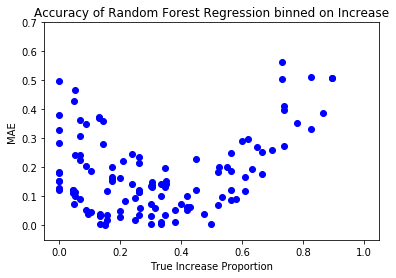

In [14]:
plt.plot(y_agg['increase'],increase_acc['regression'],'bo')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 0.7])
plt.xlabel('True Increase Proportion')
plt.ylabel('MAE')
plt.title('Accuracy of Random Forest Regression binned on Increase')
plt.savefig('binned regression accuracy')
plt.show()

In [8]:
inc_prob_confusion

,pred_increase,pred_decrease
true_increase,3,28
true_decrease,14,75


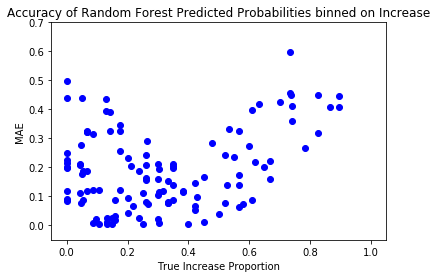

In [16]:
plt.plot(y_agg['increase'],increase_acc['pred_prob'],'bo')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 0.7])
plt.xlabel('True Increase Proportion')
plt.ylabel('MAE')
plt.title('Accuracy of Random Forest Predicted Probabilities binned on Increase')
plt.show()

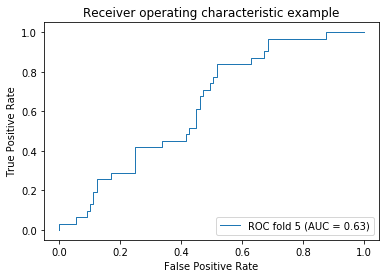

In [17]:
true_labels = y_agg['increase'].where(y_agg['increase']>=0.5,0).where(y_agg['increase']<0.5,1)
fpr, tpr, thresholds = roc_curve(true_labels,increase_pred['pred_prob'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1,label='ROC fold %d (AUC = %0.2f)' % (5, roc_auc))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
true_labels = y_agg['increase'].where(y_agg['increase']>=0.5,0).where(y_agg['increase']<0.5,1)
log_loss(true_labels,increase_pred['pred_prob'])

0.5628534736257879

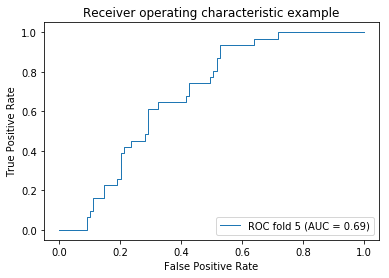

In [19]:
true_labels = y_agg['increase'].where(y_agg['increase']>=0.5,0).where(y_agg['increase']<0.5,1)
fpr, tpr, thresholds = roc_curve(true_labels,increase_pred['regression'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1,label='ROC fold %d (AUC = %0.2f)' % (5, roc_auc))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [20]:
inc_tree_confusion

,pred_increase,pred_decrease
true_increase,9,22
true_decrease,12,77


In [21]:
dec_reg_confusion

,pred_increase,pred_decrease
true_increase,25,17
true_decrease,6,72


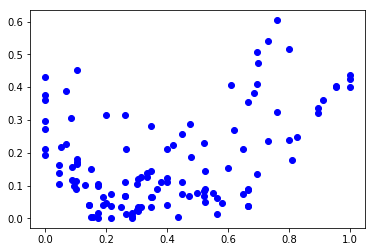

In [22]:
plt.plot(y_agg['decrease'],decrease_acc['regression'],'bo')

In [23]:
dec_prob_confusion

,pred_increase,pred_decrease
true_increase,17,25
true_decrease,13,65


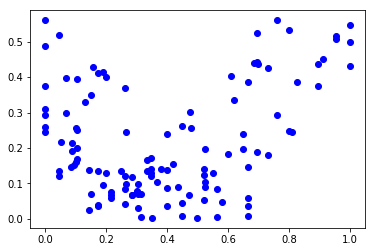

In [24]:
plt.plot(y_agg['decrease'],decrease_acc['pred_prob'],'bo')

In [25]:
inc_tree_confusion

,pred_increase,pred_decrease
true_increase,9,22
true_decrease,12,77


In [26]:
dec_tree_confusion

,pred_increase,pred_decrease
true_increase,21,21
true_decrease,14,64


In [27]:
inc_noclvl_confusion

,pred_increase,pred_decrease
true_increase,0,12
true_decrease,0,33


In [28]:
dec_noclvl_confusion

,pred_increase,pred_decrease
true_increase,5,9
true_decrease,2,29
